## Part 0: Environment Setup and Data Loading

### Part 0.1: Install Packages and Import Libraries

In [ ]:
# JVM and Spark download
!apt-get install openjdk-8-jdk-headless -qq > /dev/null  
!wget -q https://dlcdn.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop3.tgz
!tar xf spark-3.3.0-bin-hadoop3.tgz
# Enviornment configuration
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.3.0-bin-hadoop3'
# Find Spark
!pip install -q findspark
import findspark
findspark.init()
findspark.find()
# Create a Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
from pyspark.sql.functions import col
spark

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

### Part 0.2: Load Data

In [ ]:
# Mount Google Drive Folder
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load datasets
path_movies = '/content/drive/MyDrive/Projects/Datasets/Movie/Netflix_Dataset_Movie.csv'
path_ratings = '/content/drive/MyDrive/Projects/Datasets/Movie/Netflix_Dataset_Rating.csv'
df_movies = spark.read.load(path_movies, format='csv', header = True)
df_ratings = spark.read.load(path_ratings, format='csv', header = True)

### Part 0.3: View the Raw Data

In [ ]:
# Show movies
df_movies.show(10)

+--------+----+--------------------+
|Movie_ID|Year|                Name|
+--------+----+--------------------+
|       1|2003|     Dinosaur Planet|
|       2|2004|Isle of Man TT 20...|
|       3|1997|           Character|
|       4|1994|Paula Abdul's Get...|
|       5|2004|The Rise and Fall...|
|       6|1997|                Sick|
|       7|1992|               8 Man|
|       8|2004|What the #$*! Do ...|
|       9|1991|Class of Nuke 'Em...|
|      10|2001|             Fighter|
+--------+----+--------------------+
only showing top 10 rows



In [ ]:
# Number of movies
print('Number of rows in movie dataset: {}'.format(df_movies.count()))
print('Number of distinct movies in movie dataset: {}'.format(df_movies.select('Movie_ID').distinct().count()))

Number of rows in movie dataset: 17770
Number of distinct movies in movie dataset: 17770


In [ ]:
# Show ratings
df_ratings.show(10)

+-------+------+--------+
|User_ID|Rating|Movie_ID|
+-------+------+--------+
| 712664|     5|       3|
|1331154|     4|       3|
|2632461|     3|       3|
|  44937|     5|       3|
| 656399|     4|       3|
| 439011|     1|       3|
|1644750|     3|       3|
|2031561|     4|       3|
| 616720|     4|       3|
|2467008|     4|       3|
+-------+------+--------+
only showing top 10 rows



In [ ]:
# Number of ratings
print('Number of rows in the rating dataset: {}'.format(df_ratings.count()))
print('Number of distinct movie-user pairs in rating dataset: {}'.format(df_ratings.select('Movie_ID', 'User_ID').distinct().count()))

Number of rows in the rating dataset: 17337458
Number of distinct movie-user pairs in rating dataset: 17337458


## Part 1: OLAP using Spark SQL

This section explores the movie and rating datasets by investigating the following three aspects:

1. About users
- Number of users
- Number of movies rated by each user
- Minimum and maximum number of movies rated by each user
- User distribution with respect to the quantity of rated movies

2. About movies
- Number of movies
- Number of movies in each year
- Number of users rating each movie
- Minimum and maximum number of users rating each movie
- Movie distribution with respect to the quantity of raters

3. About ratings
- Distinct values of rating
- Average rating of each movie
- Movie with the highest and lowest average rating
- Movie distribution with respect to the average rating
- Average rating of movies in each year
- Best movie in each year




In [ ]:
# Create tables
df_movies.createOrReplaceTempView("movies")
df_ratings.createOrReplaceTempView("ratings")

### Part 1.1: Users

#### (a) Number of users

In [ ]:
df_num_users = spark.sql('''
    SELECT COUNT(DISTINCT User_ID) as number_of_users 
    FROM ratings
''')
df_num_users.show()

+---------------+
|number_of_users|
+---------------+
|         143458|
+---------------+



#### (b) Number of movies rated by each user

In [ ]:
df_num_movies_per_user = spark.sql('''
    SELECT User_ID AS user_id, COUNT(Movie_ID) AS number_of_movies_rated
    FROM ratings
    GROUP BY User_ID
    ORDER BY number_of_movies_rated DESC
''')
df_num_movies_per_user.show(10)

+-------+----------------------+
|user_id|number_of_movies_rated|
+-------+----------------------+
| 305344|                  1344|
| 387418|                  1339|
|2439493|                  1324|
|2118461|                  1305|
|1664010|                  1257|
| 716173|                  1169|
|1314869|                  1132|
|2056022|                  1072|
|1852040|                  1053|
|2606799|                  1039|
+-------+----------------------+
only showing top 10 rows



#### (c) Minimum and maximum number of movies rated by each user

In [ ]:
df_num_movies_per_user.createOrReplaceTempView("movies_per_user")
df_minmax_movies_per_user = spark.sql('''
    SELECT MIN(number_of_movies_rated) AS min_movies_per_user,
           MAX(number_of_movies_rated) AS max_movies_per_user  
    FROM movies_per_user
''')
df_minmax_movies_per_user.show()

+-------------------+-------------------+
|min_movies_per_user|max_movies_per_user|
+-------------------+-------------------+
|                  5|               1344|
+-------------------+-------------------+



- Comment: The users collected in the dataset have rated 5 movies at least, and 1344 movies at most.

#### (d) User distribution with respect to the quantity of rated movies

Text(0, 0.5, 'Number of users')

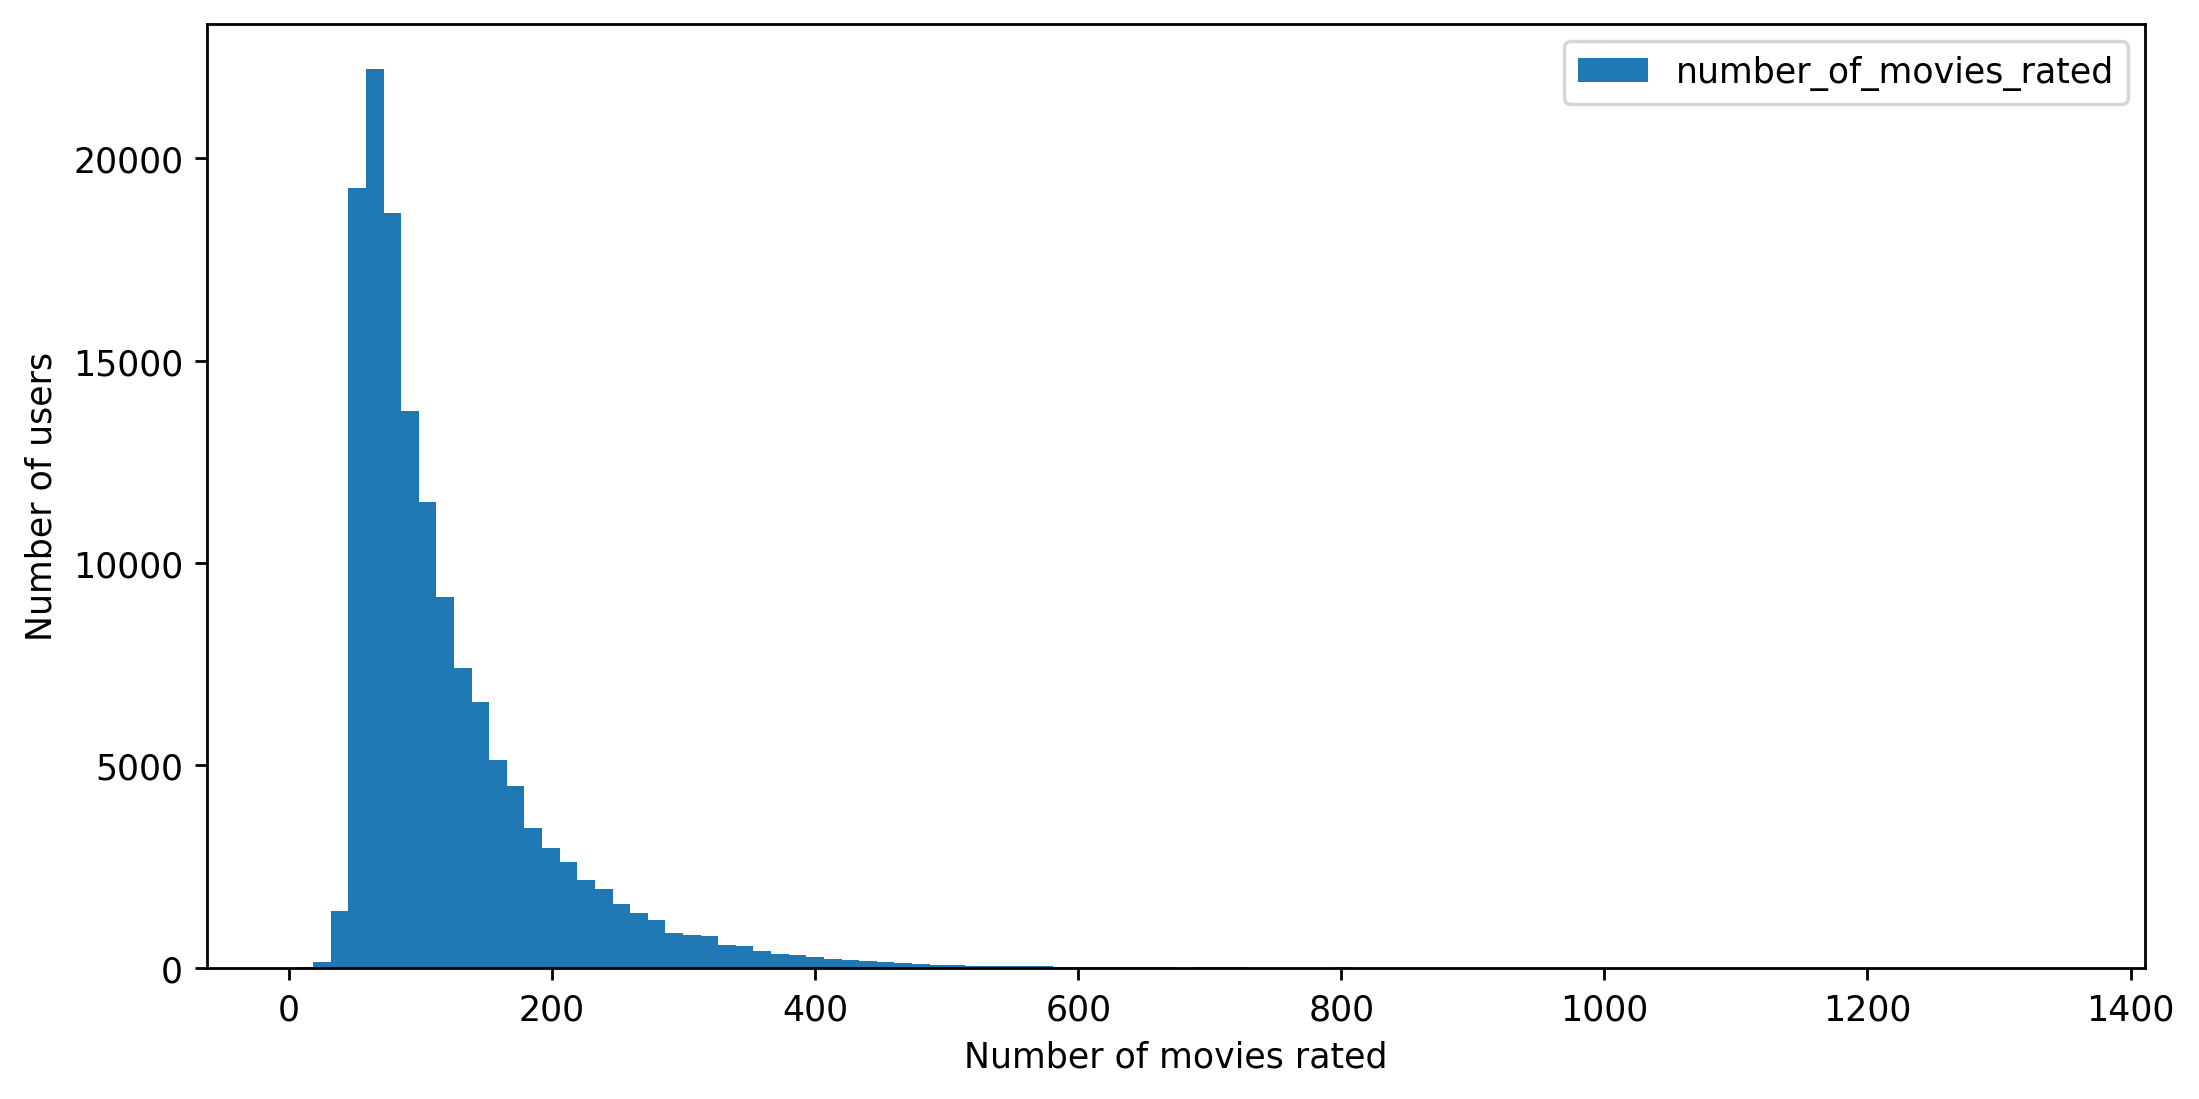

In [ ]:
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.dpi'] = 250
ax = df_num_movies_per_user.toPandas().plot.hist(bins=100)
ax.set_xlabel('Number of Movies Rated')
ax.set_ylabel('Number of Users')

In [ ]:
df_user_dist = spark.sql('''
    SELECT number_of_movies_rated, COUNT(number_of_movies_rated) AS number_of_users
    FROM (
        SELECT FLOOR(number_of_movies_rated / 50) * 50 AS floor,
               CONCAT(
                   CAST(FLOOR(number_of_movies_rated / 50) * 50 AS VARCHAR(5)),
                   '~',
                   CAST(FLOOR(number_of_movies_rated / 50) * 50 + 49 AS VARCHAR(5))
               ) AS number_of_movies_rated
        FROM movies_per_user
    )
    GROUP BY number_of_movies_rated, floor
    ORDER BY floor
''')
df_user_dist.show(df_user_dist.count())

+----------------------+---------------+
|number_of_movies_rated|number_of_users|
+----------------------+---------------+
|                  0~49|           3496|
|                 50~99|          72846|
|               100~149|          32471|
|               150~199|          16005|
|               200~249|           8484|
|               250~299|           4524|
|               300~349|           2542|
|               350~399|           1360|
|               400~449|            742|
|               450~499|            417|
|               500~549|            205|
|               550~599|            151|
|               600~649|             82|
|               650~699|             46|
|               700~749|             32|
|               750~799|             11|
|               800~849|             16|
|               850~899|              6|
|               900~949|              4|
|               950~999|              5|
|             1000~1049|              4|
|             10

- Comment: More than half of the users (72846 out of 143458) rated 50 ~ 99 movies.

### Part 1.2: Movies

#### (a) Number of movies

In [ ]:
df_num_movies = spark.sql('''
    SELECT COUNT(DISTINCT Movie_ID) as number_of_movies
    FROM movies
''')
df_num_movies.show()

+----------------+
|number_of_movies|
+----------------+
|           17770|
+----------------+



In [ ]:
df_num_movies_rated = spark.sql('''
    SELECT COUNT(DISTINCT Movie_ID) as number_of_movies_rated
    FROM ratings
''')
df_num_movies_rated.show()

+----------------------+
|number_of_movies_rated|
+----------------------+
|                  1350|
+----------------------+



- Comment: Only a smaller proportion of the movies (1350 out of 17770) are rated.

#### (b) Number of movies in each year

In [ ]:
df_num_movies_per_year = spark.sql('''
    SELECT Year, COUNT(Movie_ID) AS number_of_movies
    FROM movies
    GROUP BY Year
    ORDER BY Year
''')
df_num_movies_per_year.show(10)

+----+----------------+
|Year|number_of_movies|
+----+----------------+
|1915|              16|
|1916|               4|
|1917|               3|
|1918|               2|
|1919|               8|
|1920|               6|
|1921|               9|
|1922|               6|
|1923|               2|
|1924|               4|
+----+----------------+
only showing top 10 rows



In [ ]:
df_num_movies_per_year.createOrReplaceTempView("movies_per_year")
df_num_movies_rated_per_year = spark.sql('''
    WITH rated_movies_per_year AS (
        SELECT Year, COUNT(Movie_ID) AS number_of_movies_rated
        FROM movies
        WHERE Movie_ID IN (
            SELECT Movie_ID
            FROM ratings
        )
        GROUP BY Year
    )
    SELECT movies_per_year.Year AS Year, 
           number_of_movies,
           CASE
               WHEN number_of_movies_rated IS NOT NULL 
               THEN number_of_movies_rated
               ELSE 0
           END AS number_of_movies_rated
    FROM movies_per_year LEFT OUTER JOIN rated_movies_per_year
    ON movies_per_year.Year = rated_movies_per_year.Year
    ORDER BY Year
''')
df_num_movies_rated_per_year.show(10)

+----+----------------+----------------------+
|Year|number_of_movies|number_of_movies_rated|
+----+----------------+----------------------+
|1915|              16|                     0|
|1916|               4|                     0|
|1917|               3|                     0|
|1918|               2|                     0|
|1919|               8|                     0|
|1920|               6|                     1|
|1921|               9|                     0|
|1922|               6|                     0|
|1923|               2|                     0|
|1924|               4|                     0|
+----+----------------+----------------------+
only showing top 10 rows



Text(0, 0.5, 'Number of Movies')

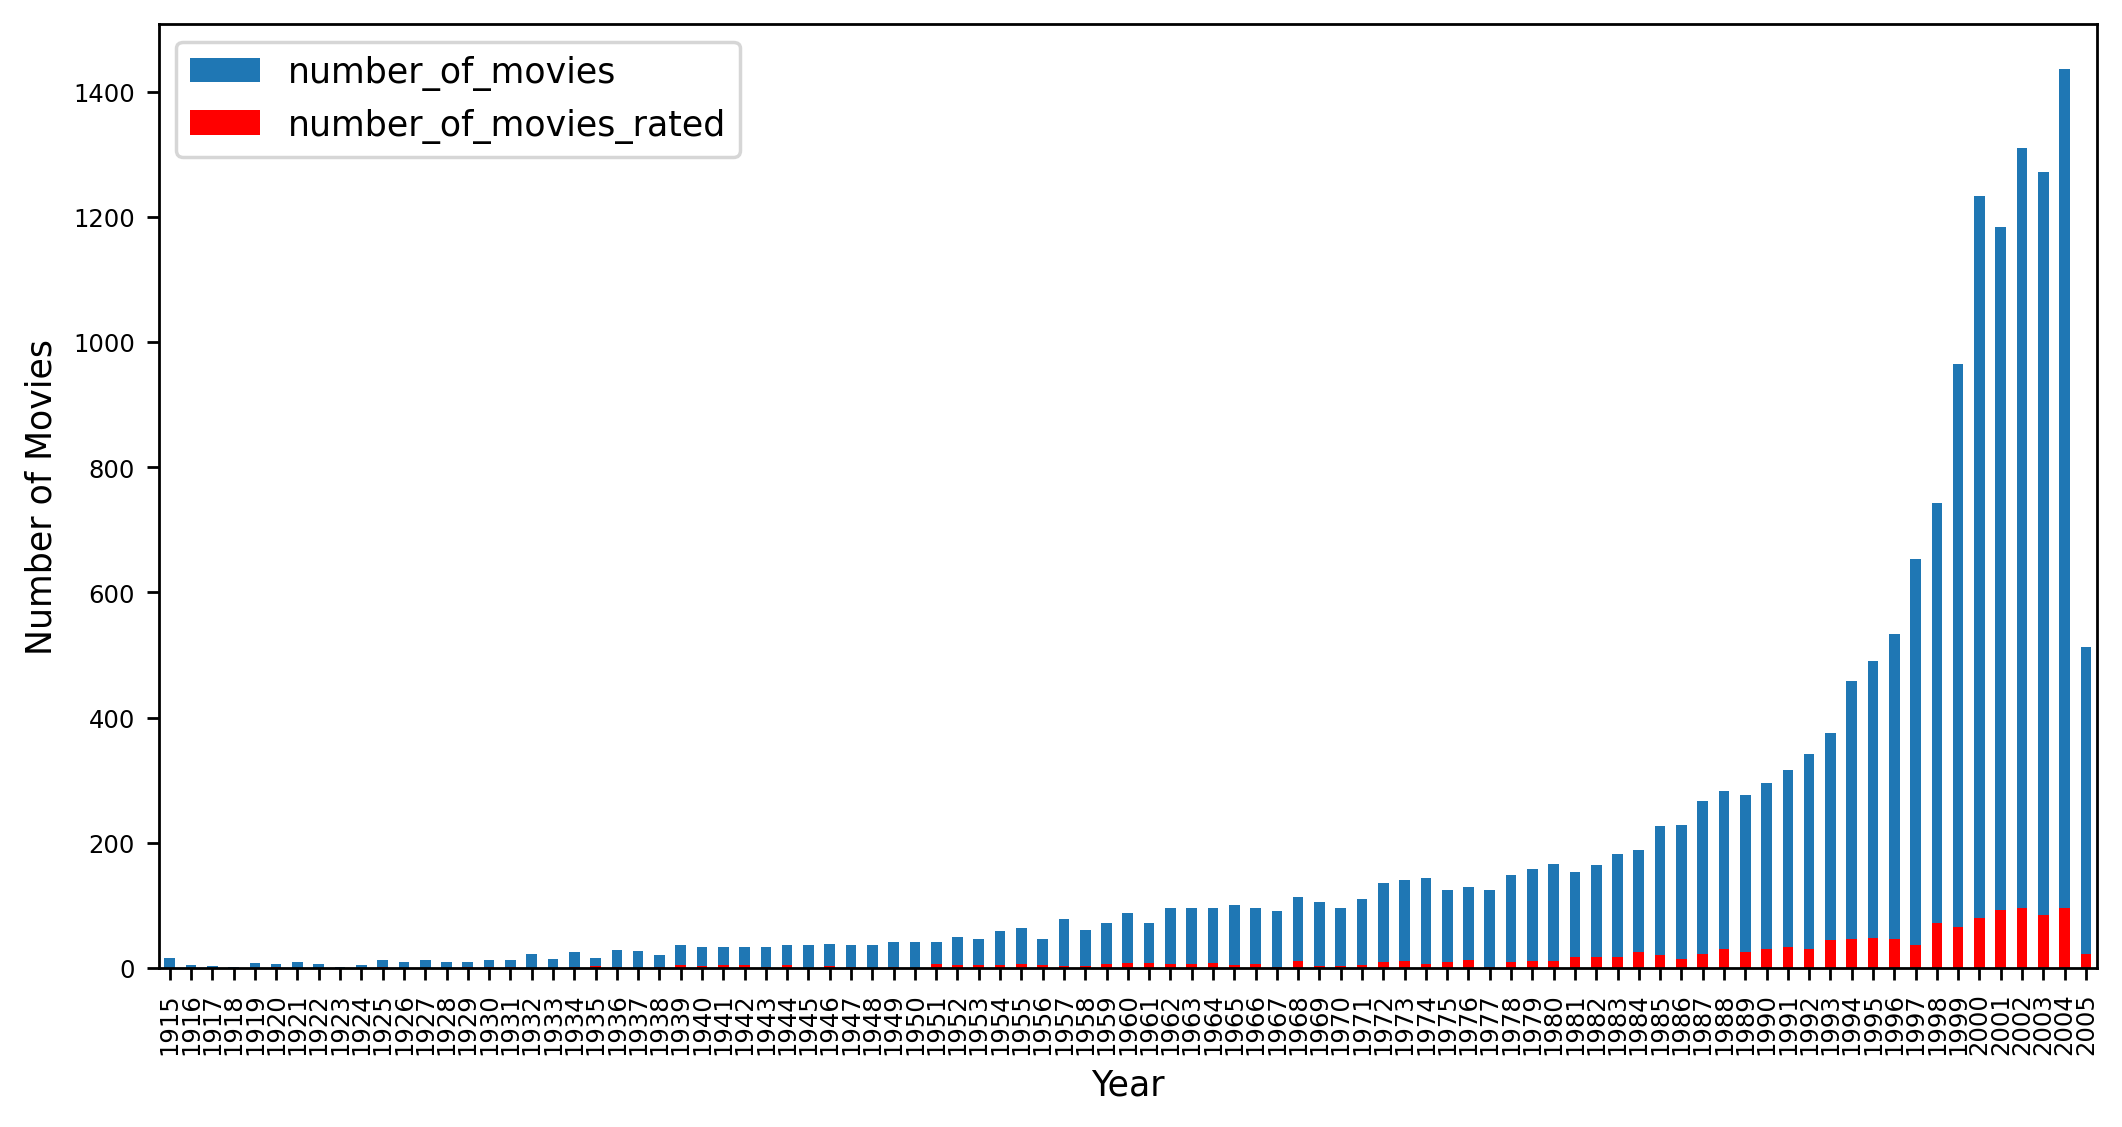

In [ ]:
ax = df_num_movies_rated_per_year.toPandas().plot.bar(x='Year', y='number_of_movies', fontsize=7)
df_num_movies_rated_per_year.toPandas().plot.bar(x='Year', y='number_of_movies_rated', ax=ax, color='red')
ax.set_xlabel('Year')
ax.set_ylabel('Number of Movies')

- Comment: Movies in the dataset are from 1915 to 2005, a great proportion of which published after 1990. The red bars of the above figure denote rated movies.

#### (c) Number of users rating each movie

In [ ]:
df_num_users_per_movie = spark.sql('''
    SELECT Movie_ID, COUNT(User_ID) AS number_of_users
    FROM ratings
    GROUP BY Movie_ID
    ORDER BY number_of_users DESC
''')
df_num_users_per_movie.show(10)

+--------+---------------+
|Movie_ID|number_of_users|
+--------+---------------+
|    1905|         117075|
|    2452|         102721|
|    4306|         102376|
|     571|         101450|
|    3860|          98545|
|    2862|          95053|
|    3962|          94235|
|    4432|          93886|
|    3938|          92893|
|    2782|          91502|
+--------+---------------+
only showing top 10 rows



#### (d) Minimum and maximum number of users rating each movie

In [ ]:
df_num_users_per_movie.createOrReplaceTempView("users_per_movie")
df_minmax_users_per_movie = spark.sql('''
    SELECT MIN(number_of_users) AS min_number_of_users,
           MAX(number_of_users) AS max_number_of_users  
    FROM users_per_movie
''')
df_minmax_users_per_movie.show()

+-------------------+-------------------+
|min_number_of_users|max_number_of_users|
+-------------------+-------------------+
|               1042|             117075|
+-------------------+-------------------+



- Comment: The rated movies in the dataset are rated by 1042 users at least, and 117075 users at most.

#### (e) Movie distribution with respect to the quantity of raters

Text(0, 0.5, 'Number of Movies')

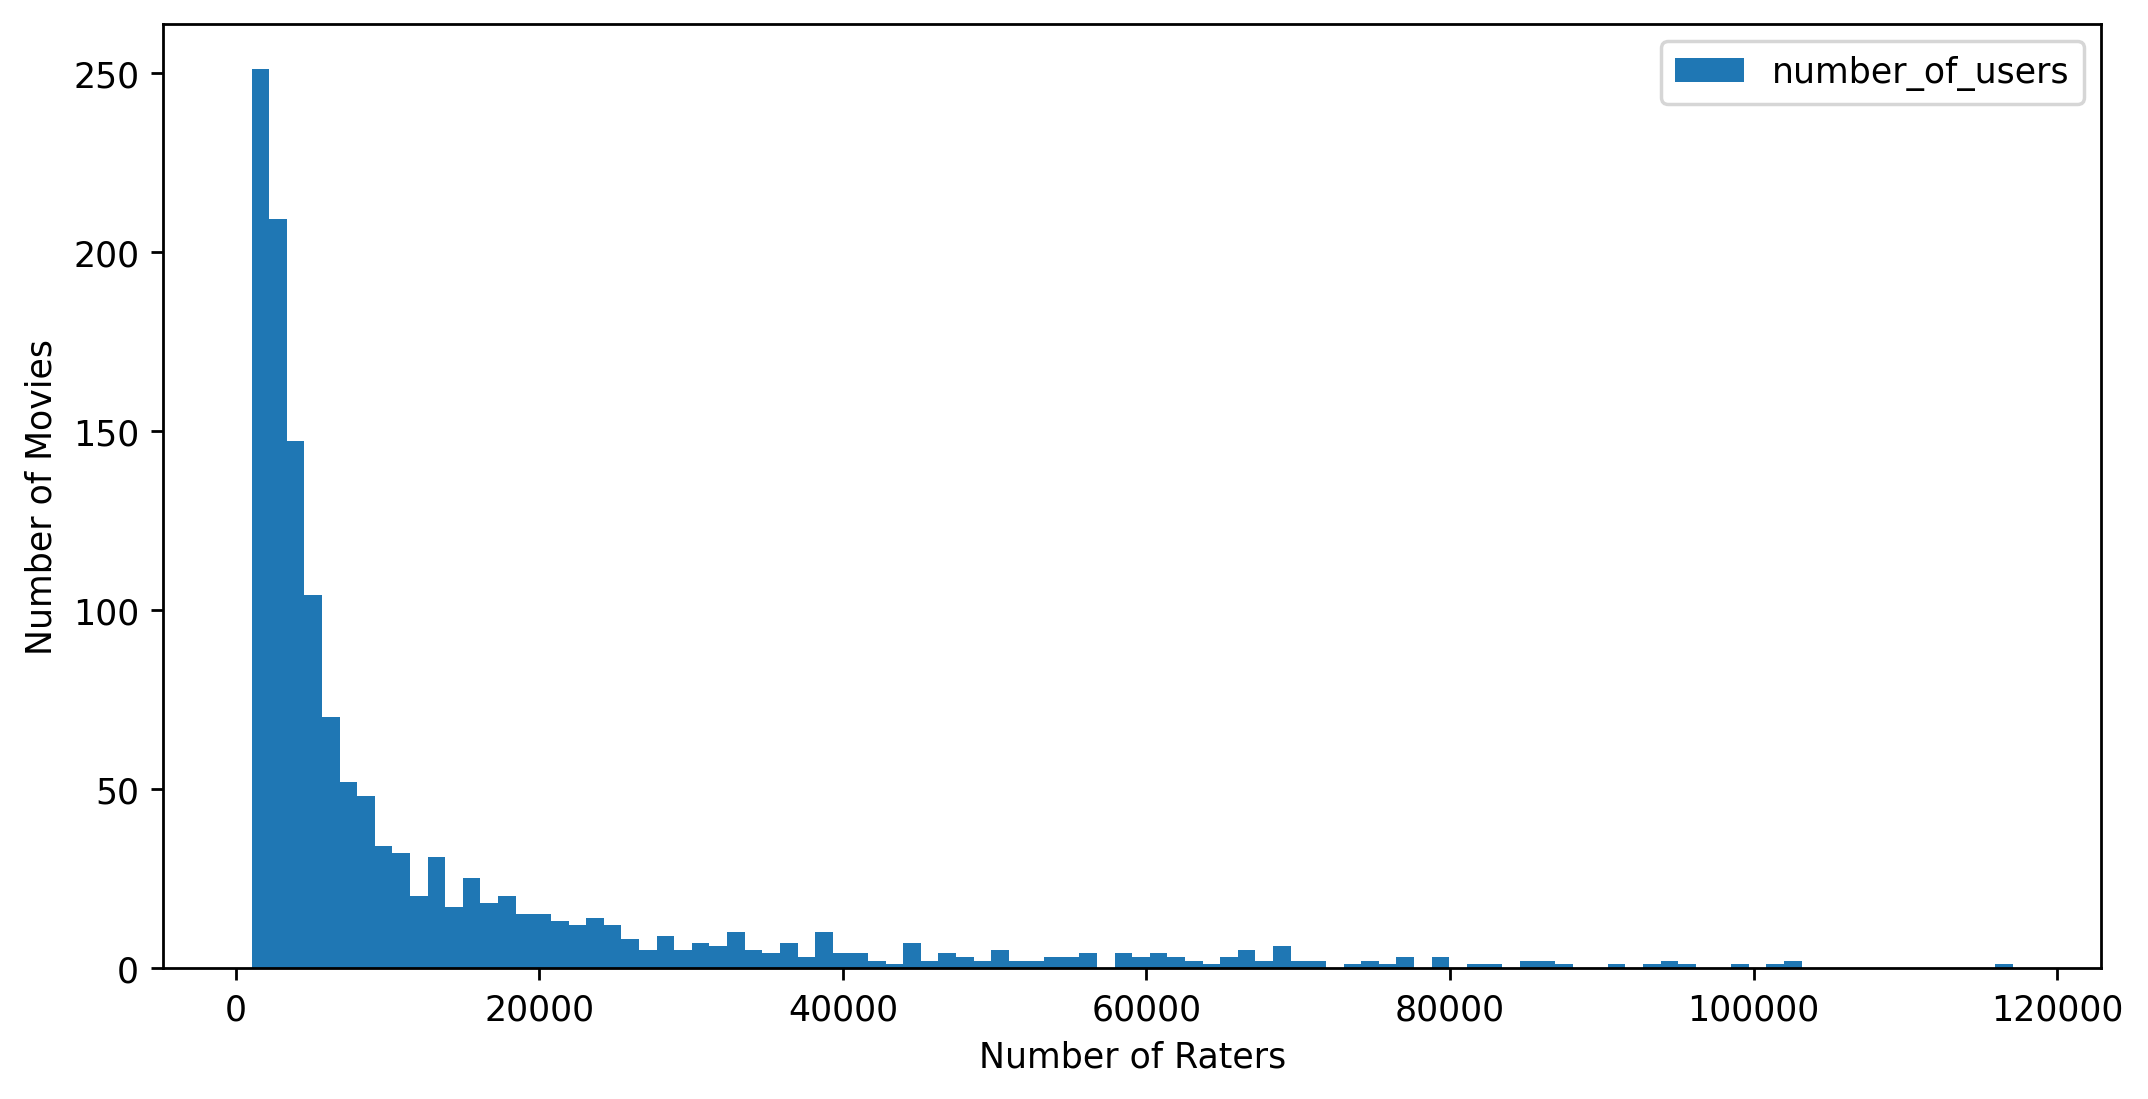

In [ ]:
ax = df_num_users_per_movie.toPandas().plot.hist(bins=100)
ax.set_xlabel('Number of Raters')
ax.set_ylabel('Number of Movies')

- Comment: Most rated movies in the dataset have 1000 ~ 20000 raters.

### Part 1.3: Ratings

#### (a) Distinct values of rating

In [ ]:
df_rating_values = spark.sql('''
    SELECT DISTINCT Rating
    FROM ratings
    ORDER BY Rating
''')
df_rating_values.show()

+------+
|Rating|
+------+
|     1|
|     2|
|     3|
|     4|
|     5|
+------+



- Comment: Only five possible values of rating (1, 2, 3, 4, 5).

#### (b) Average rating of each movie

In [ ]:
df_movie_avg_rating = spark.sql('''
    WITH movie_avg_rating AS (
        SELECT Movie_ID, ROUND(AVG(Rating), 3) AS average_rating
        FROM ratings
        GROUP BY Movie_ID
    )
    SELECT movies.Movie_ID AS Movie_ID, Name, Year, average_rating
    FROM movie_avg_rating JOIN movies
    ON movie_avg_rating.Movie_ID = movies.Movie_ID
    ORDER BY average_rating DESC
''')
df_movie_avg_rating.show(10, False)

+--------+---------------------------------------------+----+--------------+
|Movie_ID|Name                                         |Year|average_rating|
+--------+---------------------------------------------+----+--------------+
|3456    |Lost: Season 1                               |2004|4.665         |
|2102    |The Simpsons: Season 6                       |1994|4.59          |
|3444    |Family Guy: Freakin' Sweet Collection        |2004|4.521         |
|1476    |Six Feet Under: Season 4                     |2004|4.462         |
|4238    |Inu-Yasha                                    |2000|4.458         |
|2568    |Stargate SG-1: Season 8                      |2004|4.456         |
|1256    |The Best of Friends: Vol. 4                  |1994|4.449         |
|4427    |The West Wing: Season 3                      |2001|4.436         |
|2452    |Lord of the Rings: The Fellowship of the Ring|2001|4.431         |
|1947    |Gilmore Girls: Season 3                      |2002|4.429         |

In [ ]:
df_movie_avg_rating.orderBy("average_rating", ascending=True).show(10, False)

+--------+-------------------------------------------+----+--------------+
|Movie_ID|Name                                       |Year|average_rating|
+--------+-------------------------------------------+----+--------------+
|3021    |House of the Dead                          |2003|1.962         |
|2276    |Spice World                                |1998|2.102         |
|4255    |Gerry                                      |2002|2.204         |
|3505    |Freddy Got Fingered                        |2001|2.217         |
|749     |Ernest Goes to Jail                        |1990|2.222         |
|1100    |Dr. T & the Women                          |2000|2.254         |
|3573    |Cop and a Half                             |1993|2.275         |
|3567    |Starship Troopers 2: Hero of the Federation|2004|2.282         |
|289     |The Avengers                               |1998|2.322         |
|1293    |Children of the Corn 4: The Gathering      |1996|2.335         |
+--------+---------------

- Comment: The movie average ratings range from 1.962 to 4.665. The movies with highest ratings are: 
  - Lost: Season 1 (2004)
  - The Simpsons: Season 6 (1994)
  - Family Guy: Freakin' Sweet Collection (2004)

#### (c) Movie distribution with respect to the average rating

Text(0, 0.5, 'Number of Movies')

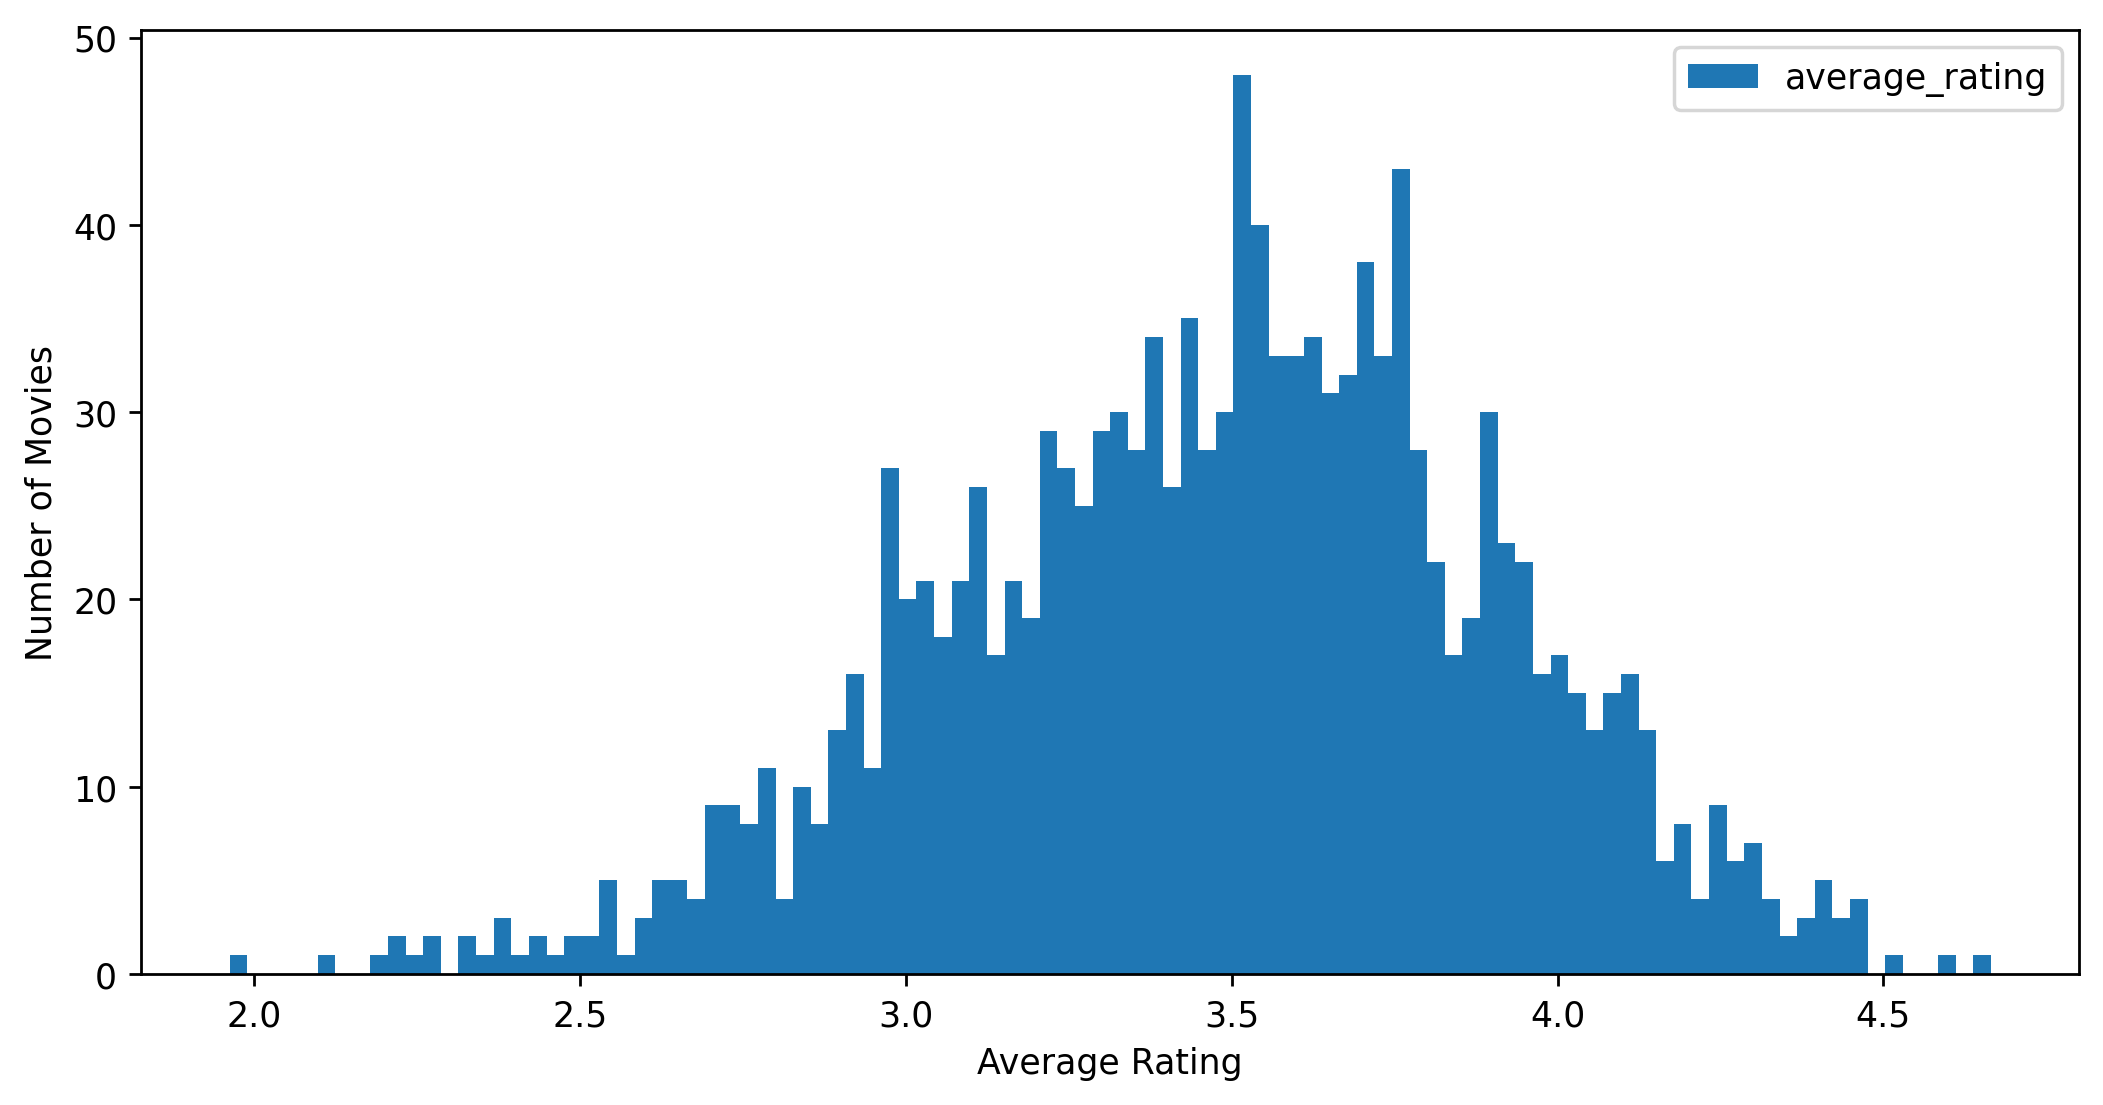

In [ ]:
ax = df_movie_avg_rating.toPandas().plot.hist(by='average_rating', bins=100)
ax.set_xlabel('Average Rating')
ax.set_ylabel('Number of Movies')

- Comment: It looks like a normal distribution with mean 3.5. Most movies have their average rating between 3.0 and 4.0.

#### (d) Average rating of movies in each year

In [ ]:
df_movie_avg_rating.createOrReplaceTempView("movie_avg_rating")
df_avg_movie_rating_each_year = spark.sql('''
    SELECT Year, AVG(average_rating) AS avg_movie_rating
    FROM movie_avg_rating
    GROUP BY Year
    ORDER BY Year
''')
df_avg_movie_rating_each_year.show(10)

+----+-----------------+
|Year| avg_movie_rating|
+----+-----------------+
|1920|            3.392|
|1925|            3.818|
|1929|            3.684|
|1930|           3.8615|
|1931|           3.8175|
|1934|            3.933|
|1935|3.941333333333333|
|1936|           3.9175|
|1938|            4.065|
|1939|            3.893|
+----+-----------------+
only showing top 10 rows



(3.0, 4.2)

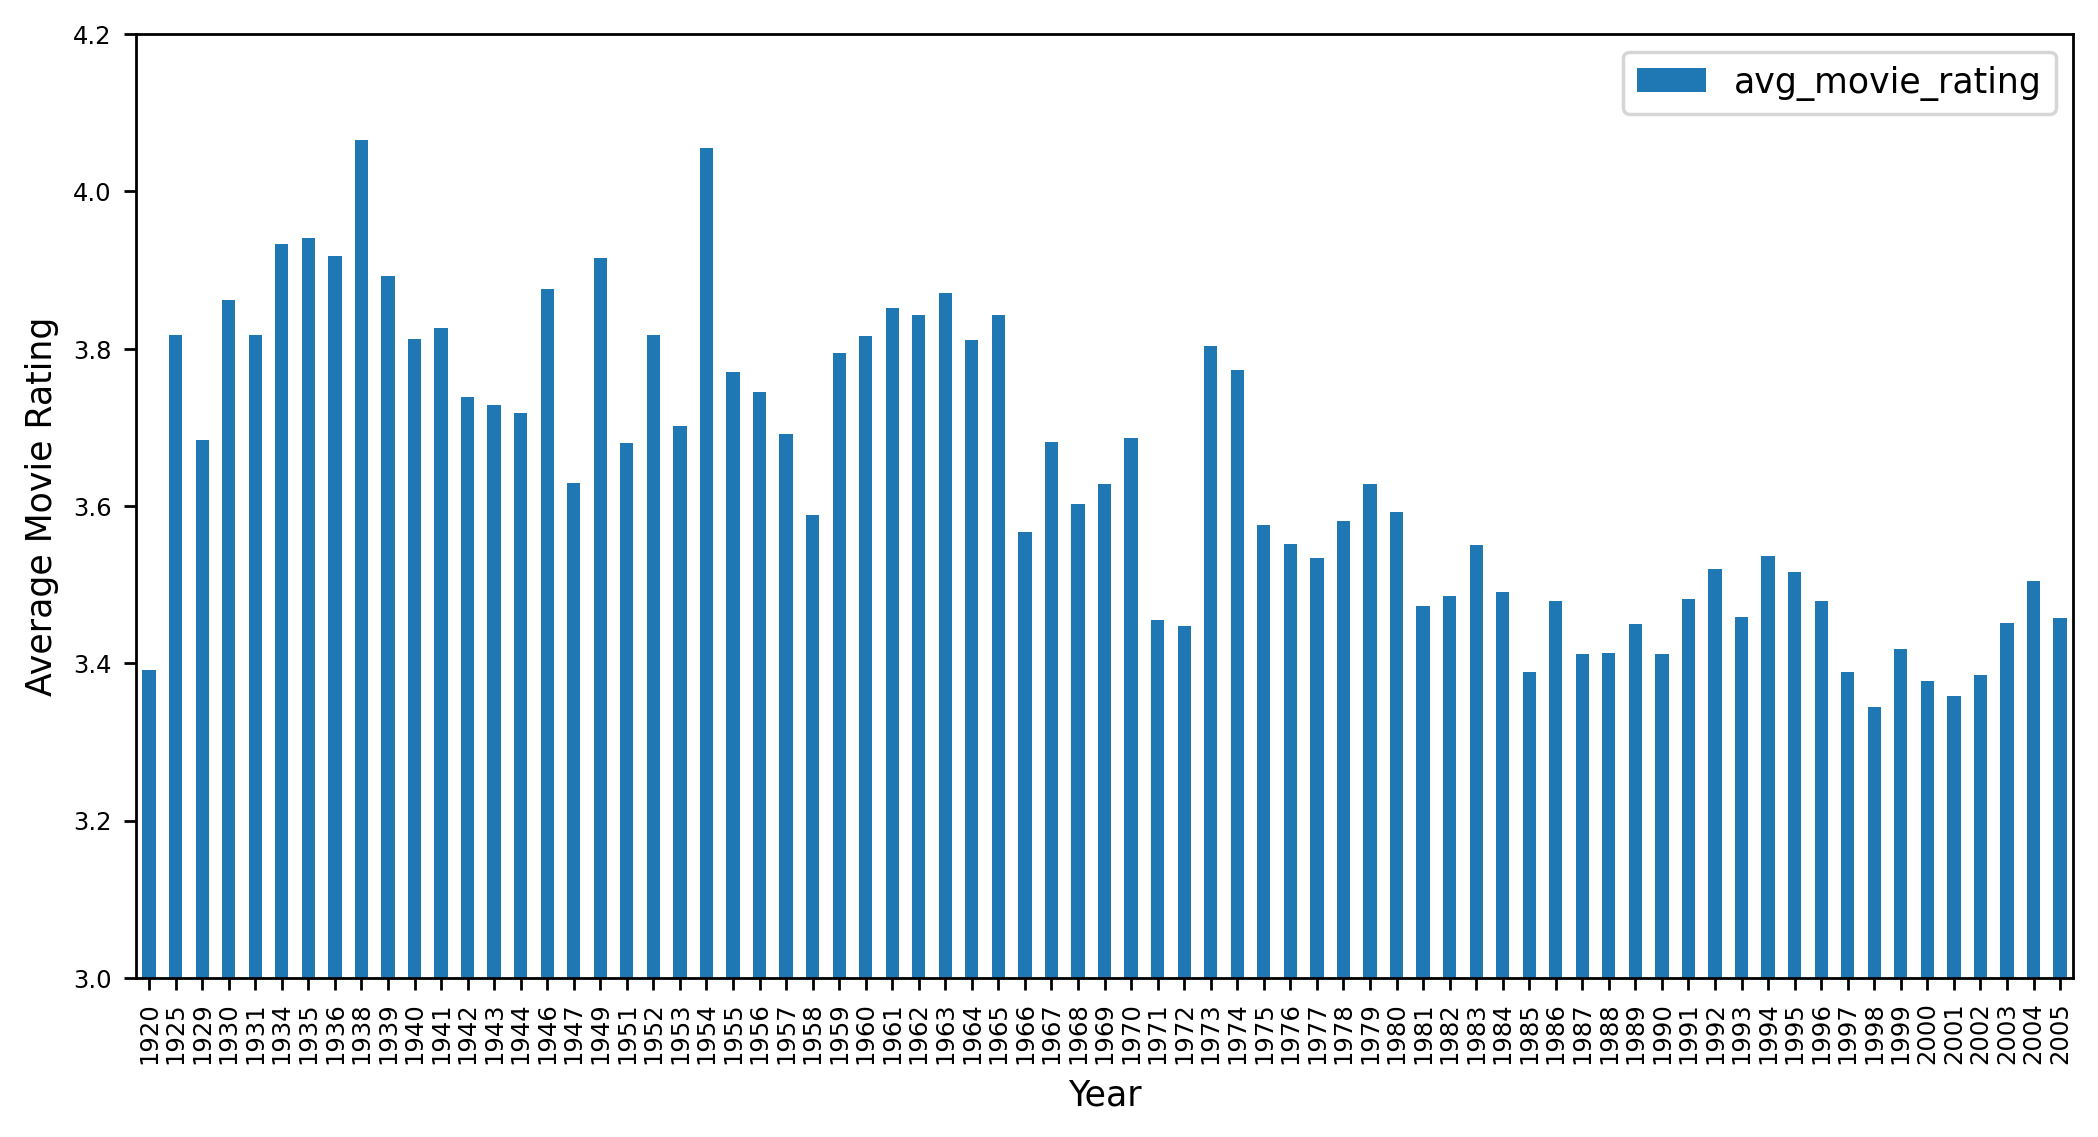

In [ ]:
ax = df_avg_movie_rating_each_year.toPandas().plot.bar(x='Year', y='avg_movie_rating', fontsize=7)
ax.set_xlabel('Year')
ax.set_ylabel('Average Movie Rating')
ax.set_ylim(3.0, 4.2)

- Comment: The average movie ratings are approximately 3.5 for each year. Movie ratings tend to decrease slowly as time passes by. There are several explanations to this phenomenon, three of them being:
    - Movie quality: the quality of recent movies might be inferior to previous ones.
    - Sample bias: the dataset tends to collect classic, great movies in the past, but includes a broader set of modern movies of various quality.
    - Number of raters: more people have watched the latest movies than the old ones, thus movies published recently have more raters. With more people evaluting the movies, the rating could hardly be very high due to the diverse taste of the population. (Those small proportion of audience who rated old movies might have watched the movies a long time ago, and they tend to give higher ratings.)

#### (e) Best movie in each year

In [ ]:
df_best_movie_each_year = spark.sql('''
    SELECT Year, Name AS movie_name, average_rating
    FROM (
        SELECT *,
            ROW_NUMBER() OVER (
                PARTITION BY Year 
                ORDER BY average_rating DESC
            ) AS row_num
        FROM movie_avg_rating
    )
    WHERE row_num = 1
    ORDER BY Year DESC
''')
df_best_movie_each_year.show(10, False)

+----+-------------------------+--------------+
|Year|movie_name               |average_rating|
+----+-------------------------+--------------+
|2005|Batman Begins            |4.244         |
|2004|Lost: Season 1           |4.665         |
|2003|Finding Nemo (Widescreen)|4.396         |
|2002|Gilmore Girls: Season 3  |4.429         |
|2001|The West Wing: Season 3  |4.436         |
|2000|Inu-Yasha                |4.458         |
|1999|Friends: Season 6        |4.359         |
|1998|Stargate SG-1: Season 2  |4.268         |
|1997|Princess Mononoke        |3.989         |
|1996|Babylon 5: Season 4      |4.204         |
+----+-------------------------+--------------+
only showing top 10 rows

